In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy import stats
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use('seaborn-white')

In [3]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=LARGE_SIZE)     
plt.rc('axes', titlesize=MEDIUM_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('axes', linewidth=0.5) 
plt.rc('xtick', labelsize=SMALL_SIZE)    
plt.rc('ytick', labelsize=SMALL_SIZE) 
plt.rc('legend', fontsize=MEDIUM_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE, dpi=300, figsize=(5,4) )  

In [4]:
path_to_data="../data/"
path_to_results="../results/"

In [5]:
plt_df=pd.read_csv(path_to_data+"Data_for_Figure5ABC.tsv",sep="\t",index_col=0)
plt_df.head()

,CancerType,Age_anno,Sex_anno,TP53_anno,Stage_anno,HRD_anno,OS,Death,DNA_damaging_drug_use,Drug_therapy_anno,...,Platinum,Topoisomerase,Hormone,ICI,Microtubule inhibitor,Molecular target,Others,PARPi,Unknown,adjuvant
P00001,THCA,Low,Female,Wt,Late,nonHRD,30.53,0.0,0.0,DNA_damaging-,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P00002,KRC,High,Male,Mut,Early,nonHRD,34.97,0.0,0.0,DNA_damaging-,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P00003,KRC,Low,Male,Wt,Early,nonHRD,57.60,0.0,0.0,DNA_damaging-,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P00004,OV,Low,Female,Mut,Late,HRD,32.53,1.0,1.0,DNA_damaging+,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
P00005,BRC,Low,Female,Wt,Early,nonHRD,0.87,1.0,0.0,DNA_damaging-,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
plt_df.shape

(9472, 23)

# Figure 5A

In [7]:
drugs=['DNA_damaging+','DNA_damaging-']

In [8]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test,multivariate_logrank_test,pairwise_logrank_test

def KMplot(data, duration="OS",duration_limit=None,event="Death",category=None,
                      title=None,ax=None,colors=None,group_order=None,
                       linewidth=None,linestyle=None,weightings=None):
    """weightings, options:'wilcoxon', 'tarone-ware' ,'peto' """
    # conditional branching by category's value types
    data=data.copy()
    if duration_limit:
        data[duration]=data[duration].clip(0,duration_limit)
    if ax==None:
        fig=plt.figure()
        ax=fig.add_subplot(111)
    if category:
        # Curate the data, by drop the raw containing "NA"
        data=data.dropna(subset=[duration,event,category])
        numbers, groups = pd.factorize(data[category])
        if group_order:
            groups=group_order
        # plot each group in one figure 
        for i, group in enumerate(groups):
            tmp_df=data[ data[category]== group]
            group_size=len(tmp_df)
            kmf = KaplanMeierFitter()
            kmf.fit(durations=tmp_df[duration], event_observed=tmp_df[event],
                        label="{} ($n$={})".format(group, group_size) )
            # options
            options={}
            if colors:
                options["c"]=colors[i]
            if linewidth:
                if type(linewidth)==list:
                    options["lw"]=linewidth[i]
                else:
                    options["lw"]=linewidth
            if linestyle:
                if type(linestyle)==list:
                    options["ls"]=linestyle[i]
                else:
                    options["ls"]=linestyle
            # plot
            kmf.plot(ax=ax,ci_show=False, **options,
                     show_censors=True,censor_styles={'ms': 2})
        
        ax.set_title("KM plot stratified by "+ category)
            
        if len(groups)==2:
            durations_A=data[ data[category]== groups[0] ][duration]
            durations_B=data[ data[category]== groups[1] ][duration]
            event_observed_A=data[ data[category]== groups[0] ][event]
            event_observed_B=data[ data[category]== groups[1] ][event]
            res=logrank_test(durations_A, durations_B, event_observed_A, event_observed_B,weightings=weightings)
            print(category,"simple log rank p= {:.2e}".format(res.summary.iloc[0,1])) 
        elif  len(groups)>2:
            res= multivariate_logrank_test(event_durations=data[duration], event_observed=data[event],
                                       groups=data[category],weightings=weightings)
            print(category,"multivariate log rank p= {:.2e}".format(res.summary.iloc[0,1])) 
        
    else:
        print("no category ?")
        data=data.dropna(subset=[duration,event]) 
        kmf = KaplanMeierFitter()
        kmf.fit(durations=data[duration],event_observed=data[event] )
        kmf.plot(ax=ax)
        ax.set_title("KM plot none stratified" )
    
    if title:
        ax.set_title(title,fontsize=8,va="bottom")
    
    ax.set_xlabel(duration,fontsize=8)
    ax.set_ylabel("survival ratio",fontsize=8)

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


HRD_anno simple log rank p= 5.14e-04
DNA_damaging+ 2984 521 2463
HRD_anno simple log rank p= 1.15e-10
DNA_damaging- 6488 594 5894


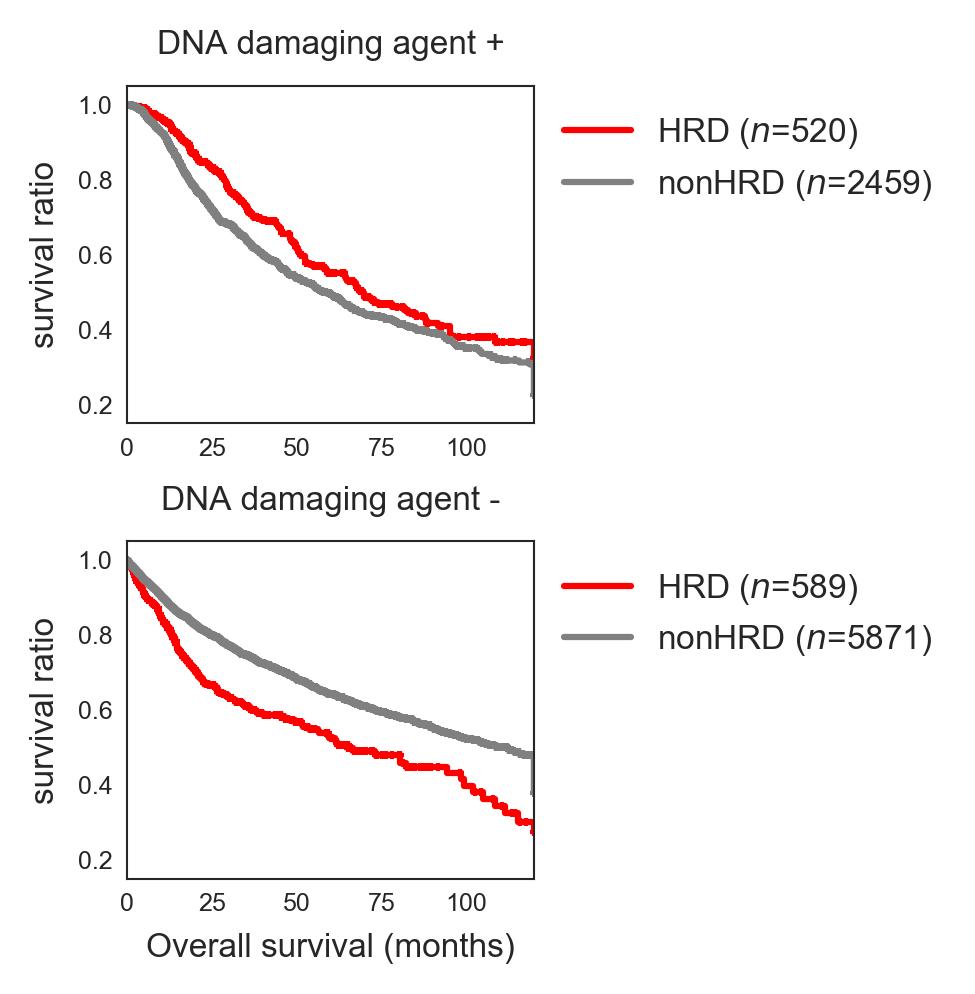

In [9]:
fig = plt.figure(figsize=(1.75,3.5))
titles=["DNA damaging agent +","DNA damaging agent -"]
for i, drug in enumerate(drugs):
    tmp_df=plt_df[ plt_df["Drug_therapy_anno"]==drugs[i] ]
    cat="HRD_anno"
    group_order=["HRD","nonHRD"]
    ax = fig.add_subplot(2,1,i+1)
    KMplot(data=tmp_df ,category=cat, duration_limit=120, 
            ax=ax,group_order=group_order,colors=["red","grey"],title=titles[i])
    
    ax.set_ylim(0.15,1.05)
    if i ==1:
        ax.set_xlabel('Overall survival (months)',fontsize=8)
    else:
        ax.set_xlabel("")
    ax.tick_params(labelsize=6)
    ax.legend(title="", frameon=False, fontsize=8, bbox_to_anchor=(1,1))
    print(drug, len(tmp_df), sum(tmp_df[cat]==group_order[0]),sum(tmp_df[cat]==group_order[1]) )

plt.subplots_adjust(hspace=0.35)
plt.savefig(path_to_results+"Figure5A.png",bbox_inches="tight")

# Figure 5B

In [10]:
covariates=['Age_anno', 'Sex_anno', 'TP53_anno', 'Stage_anno', 'HRD_anno']
categories=["Age_anno_High","Sex_anno_Male","TP53_anno_Mut","Stage_anno_Late","HRD_anno_HRD"]
duration="OS"
event="Death"

In [11]:
from lifelines import CoxPHFitter
# DNA damaging +
plt_df2=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging+"] 

# univariate analysis
cph=CoxPHFitter()
univariate_analysis=pd.DataFrame()
numbers=[]
for cov,cat in  zip( covariates, categories):
    tmp_df=plt_df2.copy()
    tmp_df=tmp_df[[duration,event,cov]].dropna()
    tmp_df=pd.get_dummies( tmp_df,drop_first=False)
    tmp_df=tmp_df[[duration,event,cat]]
    n_samples=len(tmp_df)
    n_observed= sum( tmp_df[cat]==1 )
    numbers.append( "{}({})".format(n_observed,n_samples) )
    res=cph.fit( tmp_df, duration_col=duration, event_col=event)
    add=res.summary
    univariate_analysis=pd.concat( [univariate_analysis,add], axis=0)

hrs,cis,p_values=[],[],[]
for idx in univariate_analysis.index:
    hrs.append( str( np.round(univariate_analysis.loc[idx, "exp(coef)"],2)) )
    cil=np.round( univariate_analysis.loc[idx, "exp(coef) lower 95%"] ,2)
    ciu=np.round( univariate_analysis.loc[idx, "exp(coef) upper 95%"],2)
    cis.append("{}-{}".format(cil,ciu) )
    p_values.append( "{:.2e}".format(  univariate_analysis.loc[idx,"p"] ))
    
univariate_simple=pd.DataFrame({"n":numbers,"Hazard ratio":hrs,"95%CI":cis,"p value":p_values},index=univariate_analysis.index)
univariate_simple.to_csv(path_to_results+"Figure5B_1_uni_all_dna.tsv",sep="\t")
univariate_simple

,n,Hazard ratio,95%CI,p value
Age_anno_High,1234(2979),1.76,1.56-1.99,1.10e-20
Sex_anno_Male,1135(2979),1.58,1.41-1.79,3.62e-14
TP53_anno_Mut,1585(2979),1.12,0.99-1.26,6.94e-02
Stage_anno_Late,1240(2345),2.04,1.76-2.37,1.31e-20
HRD_anno_HRD,520(2979),0.76,0.64-0.89,7.02e-04


In [12]:
# DNA damaging +
plt_df2=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging+"] 

# multivariate analysis
cph=CoxPHFitter()
tmp_df=plt_df2.copy()
tmp_df=tmp_df[[duration,event]+covariates ].dropna()
tmp_df=pd.get_dummies( tmp_df,drop_first=False)
tmp_df=tmp_df[[duration,event]+categories]
res=cph.fit( tmp_df,duration_col=duration, event_col=event,step_size=0.1)
multivariate_analysis=res.summary.loc[univariate_simple.index,:]

hrs,cis,p_values=[],[],[]
for idx in multivariate_analysis.index:
    hrs.append( str( np.round(multivariate_analysis.loc[idx, "exp(coef)"],2)) )
    cil=np.round( multivariate_analysis.loc[idx, "exp(coef) lower 95%"] ,2)
    ciu=np.round( multivariate_analysis.loc[idx, "exp(coef) upper 95%"],2)
    cis.append("{}-{}".format(cil,ciu) )
    p_values.append( "{:.2e}".format(  multivariate_analysis.loc[idx,"p"] ))
    
multivariate_simple=pd.DataFrame({"n":numbers,"Hazard ratio":hrs,"95%CI":cis,"p value":p_values},index=multivariate_analysis.index)
multivariate_simple.to_csv(path_to_results+"Figure5B_2_multi_all_dna.tsv",sep="\t")
multivariate_simple

,n,Hazard ratio,95%CI,p value
Age_anno_High,1234(2979),1.58,1.36-1.83,9.36e-10
Sex_anno_Male,1135(2979),1.4,1.2-1.62,9.83e-06
TP53_anno_Mut,1585(2979),1.36,1.17-1.58,8.51e-05
Stage_anno_Late,1240(2345),1.92,1.65-2.24,6.27e-17
HRD_anno_HRD,520(2979),0.78,0.65-0.93,6.61e-03


In [13]:
# DNA damaging -
plt_df2=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging-"] 

# univariate analysis
cph=CoxPHFitter()
univariate_analysis=pd.DataFrame()
numbers=[]
for cov,cat in  zip( covariates, categories):
    tmp_df=plt_df2.copy()
    tmp_df=tmp_df[[duration,event,cov]].dropna()
    tmp_df=pd.get_dummies( tmp_df,drop_first=False)
    tmp_df=tmp_df[[duration,event,cat]]
    n_samples=len(tmp_df)
    n_observed= sum( tmp_df[cat]==1 )
    numbers.append( "{}({})".format(n_observed,n_samples) )
    res=cph.fit( tmp_df, duration_col=duration, event_col=event)
    add=res.summary
    univariate_analysis=pd.concat( [univariate_analysis,add], axis=0)
    
hrs,cis,p_values=[],[],[]
for idx in univariate_analysis.index:
    hrs.append( str( np.round(univariate_analysis.loc[idx, "exp(coef)"],2)) )
    cil=np.round( univariate_analysis.loc[idx, "exp(coef) lower 95%"] ,2)
    ciu=np.round( univariate_analysis.loc[idx, "exp(coef) upper 95%"],2)
    cis.append("{}-{}".format(cil,ciu) )
    p_values.append( "{:.2e}".format(  univariate_analysis.loc[idx,"p"] ))
    
univariate_simple=pd.DataFrame({"n":numbers,"Hazard ratio":hrs,"95%CI":cis,"p value":p_values},index=univariate_analysis.index)
univariate_simple.to_csv(path_to_results+"Figure5B_3_uni_all_nondna.tsv",sep="\t")
univariate_simple

,n,Hazard ratio,95%CI,p value
Age_anno_High,3479(6460),2.15,1.94-2.37,2.33e-50
Sex_anno_Male,3417(6460),1.18,1.07-1.3,5.67e-04
TP53_anno_Mut,2089(6460),2.0,1.82-2.2,4.69e-47
Stage_anno_Late,1743(5236),2.83,2.56-3.13,2.10e-91
HRD_anno_HRD,589(6460),1.59,1.38-1.83,2.75e-10


In [14]:
# DNA damaging -
plt_df2=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging-"] 

# multivariate analysis
cph=CoxPHFitter()
tmp_df=plt_df2.copy()
tmp_df=tmp_df[[duration,event]+covariates ].dropna()
tmp_df=pd.get_dummies( tmp_df,drop_first=False)
tmp_df=tmp_df[[duration,event]+categories]
res=cph.fit( tmp_df,duration_col=duration, event_col=event,step_size=0.1)
multivariate_analysis=res.summary.loc[univariate_simple.index,:]

hrs,cis,p_values=[],[],[]
for idx in multivariate_analysis.index:
    hrs.append( str( np.round(multivariate_analysis.loc[idx, "exp(coef)"],2)) )
    cil=np.round( multivariate_analysis.loc[idx, "exp(coef) lower 95%"] ,2)
    ciu=np.round( multivariate_analysis.loc[idx, "exp(coef) upper 95%"],2)
    cis.append("{}-{}".format(cil,ciu) )
    p_values.append( "{:.2e}".format(  multivariate_analysis.loc[idx,"p"] ))
    
multivariate_simple=pd.DataFrame({"n":numbers,"Hazard ratio":hrs,"95%CI":cis,"p value":p_values},index=multivariate_analysis.index)
multivariate_simple.to_csv(path_to_results+"Figure5B_4_multi_all_nondna.tsv",sep="\t")
multivariate_simple

,n,Hazard ratio,95%CI,p value
Age_anno_High,3479(6460),1.91,1.71-2.13,9.82e-31
Sex_anno_Male,3417(6460),1.2,1.09-1.33,4.10e-04
TP53_anno_Mut,2089(6460),1.65,1.49-1.82,1.11e-21
Stage_anno_Late,1743(5236),2.61,2.36-2.89,3.52e-77
HRD_anno_HRD,589(6460),1.58,1.36-1.84,2.84e-09


# Figure 5C

In [15]:
# Firstly try univariate analysis per cancer, and then curate cancer types
dict_cancer_uni={}
dict_cancer_uni2={}

In [16]:
cancer_names=sorted(plt_df["CancerType"].unique())

In [17]:
# DNA damaging +
tmp_df=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging+"]

# reduce covariates per cancer type
for i,cancer in enumerate(cancer_names):
    tmp_df2=tmp_df[ tmp_df["CancerType"]==cancer]
    if len(tmp_df2)==0:
        continue
    covariates2=covariates.copy()
    categories2=categories.copy()
    if (sum(tmp_df2[ tmp_df2["Age_anno"]=="High"][event])==0)|(sum(tmp_df2[ tmp_df2["Age_anno"]=="Low"][event])==0):
        covariates2.remove("Age_anno")
        categories2.remove("Age_anno_High")
    if (sum(tmp_df2[tmp_df2["HRD_anno"]=="HRD"][event])==0)|(sum(tmp_df2[tmp_df2["HRD_anno"]=="nonHRD"][event])==0) :
        covariates2.remove("HRD_anno")
        categories2.remove("HRD_anno_HRD")
    if (sum(tmp_df2[tmp_df2["Sex_anno"]=="Male"][event])==0)|(sum(tmp_df2[tmp_df2["Sex_anno"]=="Female"][event])==0)|\
    (cancer in ["BRC","UCEC","UCS","PRAD","TGCT","TN_BRC","nonTN_BRC","OV"]):
        covariates2.remove("Sex_anno")
        categories2.remove("Sex_anno_Male")
    if (sum(tmp_df2[tmp_df2["Stage_anno"]=="Late"][event])==0)|(sum(tmp_df2[tmp_df2["Stage_anno"]=="Early"][event])==0):
        covariates2.remove("Stage_anno")
        categories2.remove("Stage_anno_Late")
    if (sum(tmp_df2[tmp_df2["TP53_anno"]=="Mut"][event])==0)|(sum(tmp_df2[tmp_df2["TP53_anno"]=="Wt"][event])==0):
        covariates2.remove("TP53_anno")
        categories2.remove("TP53_anno_Mut")
    if len(covariates2)==0:
        continue
        
    # univariate analysis
    univariate_integrated=pd.DataFrame()
    for cov,cat in zip(covariates2,categories2):
        cph=CoxPHFitter()
        tmp_df3=tmp_df2.copy()
        tmp_df3=tmp_df3[[duration,event,cov]].dropna()
        tmp_df3=pd.get_dummies(tmp_df3,drop_first=False)
        tmp_df3=tmp_df3[[duration,event, cat]]
        n_samples=len(tmp_df3)
        n_observed= sum(tmp_df3[cat]==1)
        res=cph.fit(tmp_df3,duration_col=duration, event_col=event,step_size=0.1)
        res2=res.summary
        res2["observed"]="{}({})".format(n_observed,n_samples)
        res2["p value"]="{:.2e}".format(float(res2["p"]))
        univariate_integrated=pd.concat( [univariate_integrated,res2],axis=0)
    hr=np.round( univariate_integrated["exp(coef)"],3)
    ci1=np.round( univariate_integrated["exp(coef) lower 95%"],3)
    ci2=np.round( univariate_integrated["exp(coef) upper 95%"],3)
    hrs=[str(x) for x in hr]
    cis=["{}-{}".format(ci1[j],ci2[j]) for j in range( len(univariate_integrated) )]
    univariate_integrated["Hazard ratio"]=hrs
    univariate_integrated["95%CI"]=cis
    
    univariate_simple=univariate_integrated[["observed","Hazard ratio","95%CI","p value"]]
    dict_cancer_uni[cancer]=univariate_simple

/usr/local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:591: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.577. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  ConvergenceWarning,
/usr/local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:591: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.500. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  ConvergenceWarning,
/usr/local/lib/python3.7/site-packages/lifelines/fitters/coxph_fitter.py:591: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.467. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the datase

In [18]:
# DNA damaging -
tmp_df=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging-"]

# reduce covariates per cancer type
for i,cancer in enumerate(cancer_names):
    tmp_df2=tmp_df[ tmp_df["CancerType"]==cancer]
    if len(tmp_df2)==0:
        continue
    covariates2=covariates.copy()
    categories2=categories.copy()
    if (sum(tmp_df2[ tmp_df2["Age_anno"]=="High"][event])==0)|(sum(tmp_df2[ tmp_df2["Age_anno"]=="Low"][event])==0):
        covariates2.remove("Age_anno")
        categories2.remove("Age_anno_High")
    if (sum(tmp_df2[tmp_df2["HRD_anno"]=="HRD"][event])==0)|(sum(tmp_df2[tmp_df2["HRD_anno"]=="nonHRD"][event])==0) :
        covariates2.remove("HRD_anno")
        categories2.remove("HRD_anno_HRD")
    if (sum(tmp_df2[tmp_df2["Sex_anno"]=="Male"][event])==0)|(sum(tmp_df2[tmp_df2["Sex_anno"]=="Female"][event])==0)|\
    (cancer in ["BRC","UCEC","UCS","PRAD","TGCT","TN_BRC","nonTN_BRC","OV"]):
        covariates2.remove("Sex_anno")
        categories2.remove("Sex_anno_Male")
    if (sum(tmp_df2[tmp_df2["Stage_anno"]=="Late"][event])==0)|(sum(tmp_df2[tmp_df2["Stage_anno"]=="Early"][event])==0):
        covariates2.remove("Stage_anno")
        categories2.remove("Stage_anno_Late")
    if (sum(tmp_df2[tmp_df2["TP53_anno"]=="Mut"][event])==0)|(sum(tmp_df2[tmp_df2["TP53_anno"]=="Wt"][event])==0):
        covariates2.remove("TP53_anno")
        categories2.remove("TP53_anno_Mut")
    if len(covariates2)==0:
        continue
        
    # univariate analysis
    univariate_integrated=pd.DataFrame()
    for cov,cat in zip(covariates2,categories2):
        cph=CoxPHFitter()
        tmp_df3=tmp_df2.copy()
        tmp_df3=tmp_df3[[duration,event,cov]].dropna()
        tmp_df3=pd.get_dummies(tmp_df3,drop_first=False)
        tmp_df3=tmp_df3[[duration,event, cat]]
        n_samples=len(tmp_df3)
        n_observed= sum(tmp_df3[cat]==1)
        res=cph.fit(tmp_df3,duration_col=duration, event_col=event,step_size=0.1)
        res2=res.summary
        res2["observed"]="{}({})".format(n_observed,n_samples)
        res2["p value"]="{:.2e}".format(float(res2["p"]))
        univariate_integrated=pd.concat( [univariate_integrated,res2],axis=0)
    hr=np.round( univariate_integrated["exp(coef)"],3)
    ci1=np.round( univariate_integrated["exp(coef) lower 95%"],3)
    ci2=np.round( univariate_integrated["exp(coef) upper 95%"],3)
    hrs=[str(x) for x in hr]
    cis=["{}-{}".format(ci1[j],ci2[j]) for j in range( len(univariate_integrated) )]
    univariate_integrated["Hazard ratio"]=hrs
    univariate_integrated["95%CI"]=cis
    
    univariate_simple=univariate_integrated[["observed","Hazard ratio","95%CI","p value"]]
    dict_cancer_uni2[cancer]=univariate_simple

In [19]:
df_w=pd.DataFrame(index=["Age_High","Sex_Male","Stage_Late","TP53_Mut","HRD_HRD"])

for k,v in dict_cancer_uni.items():
    v2=v.copy()
    v2.columns=[k+"_"+x for x in v2.columns]
    v2.index=[x.replace("_anno","") for x in v2.index]
    df_w=pd.concat([df_w,v2],sort=False,axis=1)

df_w.T.to_csv(path_to_results+"Figure5C_uni_per_cancer_dna.tsv",sep="\t")
df_w

,ACC_observed,ACC_Hazard ratio,ACC_95%CI,ACC_p value,BLCA_observed,BLCA_Hazard ratio,BLCA_95%CI,BLCA_p value,BRC_observed,BRC_Hazard ratio,...,STES_95%CI,STES_p value,UCEC_observed,UCEC_Hazard ratio,UCEC_95%CI,UCEC_p value,UCS_observed,UCS_Hazard ratio,UCS_95%CI,UCS_p value
Age_High,1(3),10549368.334,0.0-inf,9.94e-01,70(106),1.337,0.686-2.604,3.93e-01,132(484),1.86,...,0.861-2.215,1.81e-01,99(168),1.365,0.713-2.617,3.48e-01,34(37),0.985,0.226-4.291,9.84e-01
Sex_Male,NaN,NaN,NaN,NaN,76(106),1.239,0.61-2.515,5.54e-01,NaN,NaN,...,0.794-2.306,2.66e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stage_Late,NaN,NaN,NaN,NaN,75(104),0.889,0.446-1.772,7.38e-01,125(479),3.269,...,0.931-2.596,9.15e-02,94(168),3.402,1.557-7.43,2.13e-03,19(37),1.948,0.804-4.72,1.40e-01
TP53_Mut,NaN,NaN,NaN,NaN,58(106),0.925,0.506-1.692,8.01e-01,199(484),1.305,...,0.501-1.262,3.31e-01,95(168),1.92,0.949-3.881,6.94e-02,35(37),0.639,0.146-2.793,5.52e-01
HRD_HRD,1(3),10549368.334,0.0-inf,9.94e-01,18(106),0.506,0.199-1.29,1.54e-01,117(484),0.702,...,0.509-1.588,7.14e-01,10(168),0.734,0.177-3.056,6.71e-01,4(37),0.963,0.273-3.401,9.54e-01


In [20]:
df_w=pd.DataFrame(index=["Age_High","Sex_Male","Stage_Late","TP53_Mut","HRD_HRD"])

for k,v in dict_cancer_uni2.items():
    v2=v.copy()
    v2.columns=[k+"_"+x for x in v2.columns]
    v2.index=[x.replace("_anno","") for x in v2.index]
    df_w=pd.concat([df_w,v2],sort=False,axis=1)

df_w.T.to_csv(path_to_results+"Figure5C_uni_per_cancer_nondna.tsv",sep="\t")
df_w

,ACC_observed,ACC_Hazard ratio,ACC_95%CI,ACC_p value,BLCA_observed,BLCA_Hazard ratio,BLCA_95%CI,BLCA_p value,BRC_observed,BRC_Hazard ratio,...,UCEC_95%CI,UCEC_p value,UCS_observed,UCS_Hazard ratio,UCS_95%CI,UCS_p value,UVM_observed,UVM_Hazard ratio,UVM_95%CI,UVM_p value
Age_High,21(87),1.394,0.641-3.031,4.02e-01,224(292),2.014,1.238-3.274,4.78e-03,302(494),1.346,...,1.409-6.532,4.55e-03,15(19),1.966,0.253-15.265,5.18e-01,40(76),2.884,0.893-9.316,7.67e-02
Sex_Male,31(87),0.99,0.474-2.067,9.79e-01,218(292),0.776,0.535-1.126,1.82e-01,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,43(76),1.391,0.463-4.174,5.56e-01
Stage_Late,33(85),7.424,3.244-16.991,2.08e-06,191(292),3.207,2.058-5.0,2.67e-07,104(481),2.717,...,2.447-8.389,1.53e-06,11(19),2.411,0.659-8.823,1.84e-01,38(76),2.812,0.781-10.126,1.14e-01
TP53_Mut,18(87),3.756,1.718-8.211,9.11e-04,139(292),1.054,0.748-1.483,7.65e-01,135(494),1.461,...,1.176-3.88,1.27e-02,16(19),0.433,0.114-1.644,2.19e-01,NaN,NaN,NaN,NaN
HRD_HRD,11(87),2.641,1.133-6.156,2.45e-02,42(292),1.059,0.664-1.69,8.09e-01,78(494),1.101,...,1.468-7.441,3.89e-03,2(19),1.735,0.367-8.199,4.87e-01,NaN,NaN,NaN,NaN


In [21]:
# selecte cancer types for multivariate analysis
# keep the cancertype whose number of cases >= 5 cases 
limit=5
selected_cancers=[]
for k,v in dict_cancer_uni.items():
    if "HRD_anno_HRD" in v.index:
        observed=int( v.loc["HRD_anno_HRD","observed"].split("(")[0] )
        if observed >=limit:
            if k in dict_cancer_uni2:
                observed2=int(  dict_cancer_uni2[k].loc["HRD_anno_HRD","observed"].split("(")[0] )
                if observed2>=limit:
                    selected_cancers.append(k)
print(selected_cancers)

['BLCA', 'BRC', 'CESC', 'CRC', 'HNSC', 'LUAD', 'LUSC', 'MESO', 'OV', 'SARC', 'SKCM', 'STES', 'UCEC']


In [22]:
dict_cancer_multi={}
dict_cancer_multi2={}

In [23]:
tmp_df=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging+"]

# reduce covariates per cancer type
for i,cancer in enumerate(selected_cancers):
    tmp_df2=tmp_df[ tmp_df["CancerType"]==cancer]
    if len(tmp_df2)==0:
        continue
    covariates2=covariates.copy()
    categories2=categories.copy()
    if (sum(tmp_df2[ tmp_df2["Age_anno"]=="High"][event])==0)|(sum(tmp_df2[ tmp_df2["Age_anno"]=="Low"][event])==0):
        covariates2.remove("Age_anno")
        categories2.remove("Age_anno_High")
    if (sum(tmp_df2[tmp_df2["HRD_anno"]=="HRD"][event])==0)|(sum(tmp_df2[tmp_df2["HRD_anno"]=="nonHRD"][event])==0) :
        covariates2.remove("HRD_anno")
        categories2.remove("HRD_anno_HRD")
    if (sum(tmp_df2[tmp_df2["Sex_anno"]=="Male"][event])==0)|(sum(tmp_df2[tmp_df2["Sex_anno"]=="Female"][event])==0)|\
    (cancer in ["BRC","UCEC","UCS","PRAD","TGCT","TN_BRC","nonTN_BRC","OV"]):
        covariates2.remove("Sex_anno")
        categories2.remove("Sex_anno_Male")
    if (sum(tmp_df2[tmp_df2["Stage_anno"]=="Late"][event])==0)|(sum(tmp_df2[tmp_df2["Stage_anno"]=="Early"][event])==0):
        covariates2.remove("Stage_anno")
        categories2.remove("Stage_anno_Late")
    if (sum(tmp_df2[tmp_df2["TP53_anno"]=="Mut"][event])==0)|(sum(tmp_df2[tmp_df2["TP53_anno"]=="Wt"][event])==0):
        covariates2.remove("TP53_anno")
        categories2.remove("TP53_anno_Mut")
    if len(covariates2)==0:
        continue
    
    # multivariate analysis
    multivariate_integrated=pd.DataFrame()
    cph=CoxPHFitter()
    tmp_df3=tmp_df2.copy()
    tmp_df3=tmp_df3[[duration,event]+covariates2].dropna()
    tmp_df3=pd.get_dummies(tmp_df3,drop_first=False)
    tmp_df3=tmp_df3[[duration,event]+categories2]
    res=cph.fit( tmp_df3,duration_col=duration, event_col=event,step_size=0.1)
    res2=res.summary
    n_samples=[len(~tmp_df2[cov].isna()) for cat in covariates2] 
    n_observed=[ sum( tmp_df2[cov]==cat.split("_")[-1] )  for cat,cov in zip(categories2,covariates2)]
    hr=np.round( res2["exp(coef)"],3)
    ci1=np.round( res2["exp(coef) lower 95%"],3)
    ci2=np.round( res2["exp(coef) upper 95%"],3)
    res2["p value"]=["{:.2e}".format(x) for x in res2["p"] ]
    res2["Hazard ratio"]=hr
    res2["95%CI"]=["{}-{}".format(x,y) for x,y in zip(ci1,ci2)]
    res2["observed"]=["{}({})".format(o,s) for o,s in zip(n_observed,n_samples)]
    multivariate_simple=res2[["observed","Hazard ratio","95%CI","p value"]]
    dict_cancer_multi[cancer]=multivariate_simple

In [24]:
tmp_df=plt_df[plt_df["Drug_therapy_anno"]=="DNA_damaging-"]

# reduce covariates per cancer type
for i,cancer in enumerate(selected_cancers):
    tmp_df2=tmp_df[ tmp_df["CancerType"]==cancer]
    if len(tmp_df2)==0:
        continue
    covariates2=covariates.copy()
    categories2=categories.copy()
    if (sum(tmp_df2[ tmp_df2["Age_anno"]=="High"][event])==0)|(sum(tmp_df2[ tmp_df2["Age_anno"]=="Low"][event])==0):
        covariates2.remove("Age_anno")
        categories2.remove("Age_anno_High")
    if (sum(tmp_df2[tmp_df2["HRD_anno"]=="HRD"][event])==0)|(sum(tmp_df2[tmp_df2["HRD_anno"]=="nonHRD"][event])==0) :
        covariates2.remove("HRD_anno")
        categories2.remove("HRD_anno_HRD")
    if (sum(tmp_df2[tmp_df2["Sex_anno"]=="Male"][event])==0)|(sum(tmp_df2[tmp_df2["Sex_anno"]=="Female"][event])==0)|\
    (cancer in ["BRC","UCEC","UCS","PRAD","TGCT","TN_BRC","nonTN_BRC","OV"]):
        covariates2.remove("Sex_anno")
        categories2.remove("Sex_anno_Male")
    if (sum(tmp_df2[tmp_df2["Stage_anno"]=="Late"][event])==0)|(sum(tmp_df2[tmp_df2["Stage_anno"]=="Early"][event])==0):
        covariates2.remove("Stage_anno")
        categories2.remove("Stage_anno_Late")
    if (sum(tmp_df2[tmp_df2["TP53_anno"]=="Mut"][event])==0)|(sum(tmp_df2[tmp_df2["TP53_anno"]=="Wt"][event])==0):
        covariates2.remove("TP53_anno")
        categories2.remove("TP53_anno_Mut")
    if len(covariates2)==0:
        continue
    
    # multivariate analysis
    multivariate_integrated=pd.DataFrame()
    cph=CoxPHFitter()
    tmp_df3=tmp_df2.copy()
    tmp_df3=tmp_df3[[duration,event]+covariates2].dropna()
    tmp_df3=pd.get_dummies(tmp_df3,drop_first=False)
    tmp_df3=tmp_df3[[duration,event]+categories2]
    res=cph.fit( tmp_df3,duration_col=duration, event_col=event,step_size=0.1)
    res2=res.summary
    n_samples=[len(~tmp_df2[cov].isna()) for cat in covariates2] 
    n_observed=[ sum( tmp_df2[cov]==cat.split("_")[-1] )  for cat,cov in zip(categories2,covariates2)]
    hr=np.round( res2["exp(coef)"],3)
    ci1=np.round( res2["exp(coef) lower 95%"],3)
    ci2=np.round( res2["exp(coef) upper 95%"],3)
    res2["p value"]=["{:.2e}".format(x) for x in res2["p"] ]
    res2["Hazard ratio"]=hr
    res2["95%CI"]=["{}-{}".format(x,y) for x,y in zip(ci1,ci2)]
    res2["observed"]=["{}({})".format(o,s) for o,s in zip(n_observed,n_samples)]
    multivariate_simple=res2[["observed","Hazard ratio","95%CI","p value"]]
    dict_cancer_multi2[cancer]=multivariate_simple

In [25]:
df_w=pd.DataFrame(index=["Age_High","Sex_Male","Stage_Late","TP53_Mut","HRD_HRD"])

for k,v in dict_cancer_multi.items():
    v2=v.copy()
    v2.columns=[k+"_"+x for x in v2.columns]
    v2.index=[x.replace("_anno","") for x in v2.index]
    df_w=pd.concat([df_w,v2],sort=False,axis=1)

df_w.T.to_csv(path_to_results+"Figure5C_multi_per_cancer_dna.tsv",sep="\t")
df_w

,BLCA_observed,BLCA_Hazard ratio,BLCA_95%CI,BLCA_p value,BRC_observed,BRC_Hazard ratio,BRC_95%CI,BRC_p value,CESC_observed,CESC_Hazard ratio,...,SKCM_95%CI,SKCM_p value,STES_observed,STES_Hazard ratio,STES_95%CI,STES_p value,UCEC_observed,UCEC_Hazard ratio,UCEC_95%CI,UCEC_p value
Age_High,70(106),1.364,0.692-2.69,3.70e-01,132(484),1.885,0.925-3.841,8.09e-02,21(121),1.418,...,0.681-3.222,3.22e-01,115(212),1.251,0.766-2.045,3.71e-01,99(168),1.134,0.522-2.465,7.50e-01
Sex_Male,76(106),1.462,0.695-3.078,3.17e-01,NaN,NaN,NaN,NaN,NaN,NaN,...,0.434-1.79,7.27e-01,153(212),1.346,0.774-2.342,2.92e-01,NaN,NaN,NaN,NaN
Stage_Late,75(106),0.876,0.421-1.825,7.24e-01,125(484),3.538,1.81-6.915,2.19e-04,34(121),1.615,...,0.618-2.548,5.30e-01,118(212),1.470,0.869-2.488,1.51e-01,94(168),4.007,1.811-8.868,6.14e-04
TP53_Mut,58(106),0.899,0.482-1.676,7.38e-01,199(484),1.718,0.862-3.422,1.24e-01,15(121),1.643,...,0.529-3.082,5.87e-01,117(212),0.847,0.524-1.368,4.97e-01,95(168),2.232,0.965-5.162,6.05e-02
HRD_HRD,18(106),0.514,0.196-1.348,1.76e-01,117(484),0.744,0.298-1.855,5.26e-01,8(121),1.177,...,0.328-2.884,9.59e-01,45(212),0.768,0.422-1.398,3.88e-01,10(168),0.412,0.096-1.77,2.33e-01


In [26]:
df_w=pd.DataFrame(index=["Age_High","Sex_Male","Stage_Late","TP53_Mut","HRD_HRD"])

for k,v in dict_cancer_multi2.items():
    v2=v.copy()
    v2.columns=[k+"_"+x for x in v2.columns]
    v2.index=[x.replace("_anno","") for x in v2.index]
    df_w=pd.concat([df_w,v2],sort=False,axis=1)

df_w.T.to_csv(path_to_results+"Figure5C_multi_per_cancer_nondna.tsv",sep="\t")
df_w

,BLCA_observed,BLCA_Hazard ratio,BLCA_95%CI,BLCA_p value,BRC_observed,BRC_Hazard ratio,BRC_95%CI,BRC_p value,CESC_observed,CESC_Hazard ratio,...,SKCM_95%CI,SKCM_p value,STES_observed,STES_Hazard ratio,STES_95%CI,STES_p value,UCEC_observed,UCEC_Hazard ratio,UCEC_95%CI,UCEC_p value
Age_High,225(294),1.845,1.123-3.03,1.56e-02,302(494),1.716,1.08-2.729,2.24e-02,30(157),1.437,...,1.469-2.81,1.85e-05,255(378),1.265,0.896-1.786,1.81e-01,216(350),2.629,1.205-5.737,1.52e-02
Sex_Male,220(294),0.788,0.542-1.148,2.15e-01,NaN,NaN,NaN,NaN,NaN,NaN,...,0.794-1.553,5.40e-01,260(378),1.026,0.701-1.502,8.93e-01,NaN,NaN,NaN,NaN
Stage_Late,193(294),3.183,2.034-4.982,4.04e-07,104(494),2.868,1.847-4.452,2.69e-06,25(157),1.972,...,1.433-2.754,3.83e-05,176(378),3.042,2.156-4.293,2.42e-10,50(350),3.714,1.951-7.069,6.46e-05
TP53_Mut,140(294),0.975,0.689-1.379,8.85e-01,135(494),1.889,1.213-2.943,4.92e-03,NaN,NaN,...,0.421-1.091,1.10e-01,227(378),1.153,0.822-1.618,4.10e-01,96(350),1.364,0.706-2.637,3.56e-01
HRD_HRD,42(294),1.148,0.709-1.859,5.74e-01,78(494),0.986,0.562-1.729,9.60e-01,6(157),1.537,...,0.852-2.696,1.58e-01,63(378),1.177,0.778-1.78,4.42e-01,20(350),1.609,0.651-3.977,3.03e-01


In [27]:
dict_hrd_cancer_count={}
for k,v in dict_cancer_multi.items():
    n=int( v.loc["HRD_anno_HRD","observed"].split("(")[0] )
    dict_hrd_cancer_count[k]=n
    
dict_hrd_cancer_count2={}
for k,v in dict_cancer_multi2.items():
    n=int( v.loc["HRD_anno_HRD","observed"].split("(")[0] )
    dict_hrd_cancer_count2[k]=n
    
dict_hrd_cancer_count_total={}
for cancer in selected_cancers:
    n= dict_hrd_cancer_count[cancer]+dict_hrd_cancer_count2[cancer]
    dict_hrd_cancer_count_total[cancer]=n
    
dict_hrd_cancer_count_total

{'BLCA': 60,
 'BRC': 195,
 'CESC': 14,
 'CRC': 16,
 'HNSC': 49,
 'LUAD': 37,
 'LUSC': 70,
 'MESO': 24,
 'OV': 205,
 'SARC': 54,
 'SKCM': 35,
 'STES': 108,
 'UCEC': 30}

In [28]:
selected_cancers_order=['SARC', 'HNSC', 'CESC', 'CRC', 'LUAD', 'LUSC', 'MESO', 'SKCM',
 'UCEC','BLCA', "STES", 'BRC',  'OV',]

In [29]:
dict_cancer_color={
'ACC': (0.807843137254902, 0.42745098039215684, 0.7411764705882353),
 'BLCA': (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
 'BRC': (0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 'CESC': (0.4196078431372549, 0.43137254901960786, 0.8117647058823529),
 'CHOL': (0.2235294117647059, 0.23137254901960785, 0.4745098039215686),
 'CRC': (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
 'ESCA': (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 'GBM': (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 'HNSC': (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 'KRC': (1.0, 1.0, 0.6),
 'LGG': (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
 'LIHC': (0.5176470588235295, 0.23529411764705882, 0.2235294117647059),
 'LUAD': (0.6784313725490196, 0.28627450980392155, 0.2901960784313726),
 'LUSC': (0.9411764705882353, 0.00784313725490196, 0.4980392156862745),
 'MESO': (0.9058823529411765, 0.5882352941176471, 0.611764705882353),
 'OV': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'PAAD': (0.4823529411764706, 0.2549019607843137, 0.45098039215686275),
 'PCPG': (0.6470588235294118, 0.3176470588235294, 0.5803921568627451),
 'PRAD': (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
 'SARC': (0.7411764705882353, 0.6196078431372549, 0.2235294117647059),
 'SKCM': (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 'STES': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'TGCT': (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 'THCA': (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 'UCEC': (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 'UCS': (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 'UVM': (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
'Others': 'grey'}

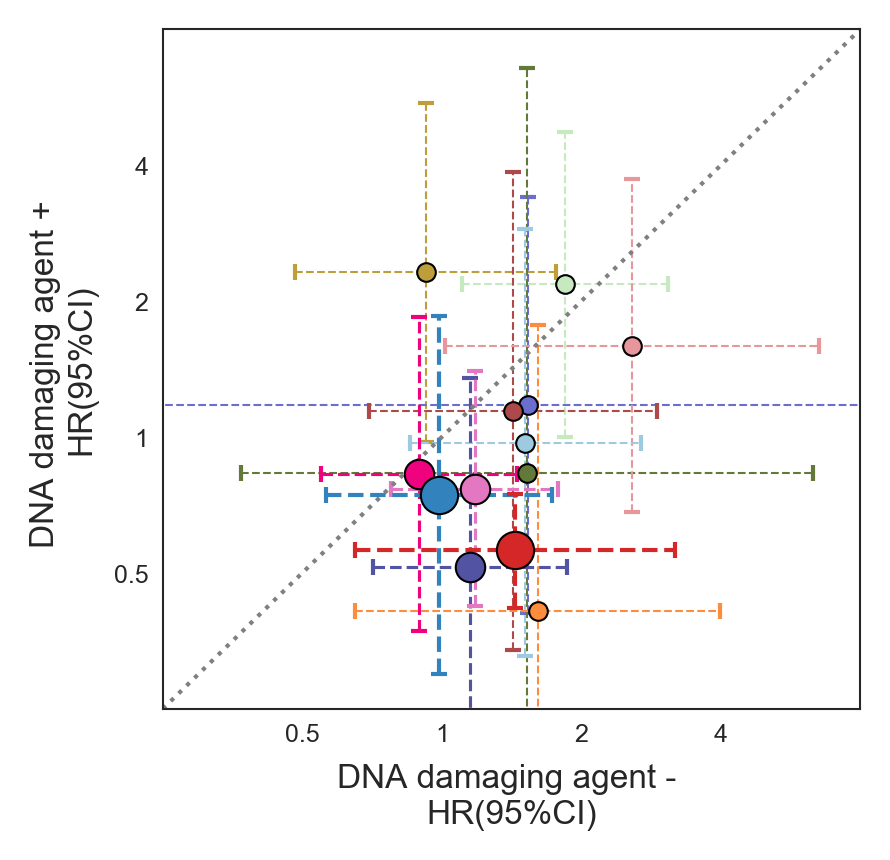

In [30]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
colors=[dict_cancer_color[cancer] for cancer in selected_cancers_order]
for i,cancer in enumerate(selected_cancers_order):
    hr_d=dict_cancer_multi[cancer].loc["HRD_anno_HRD","Hazard ratio"]
    hr_n=dict_cancer_multi2[cancer].loc["HRD_anno_HRD","Hazard ratio"]
    ci_d=dict_cancer_multi[cancer].loc["HRD_anno_HRD","95%CI"]
    ci_n=dict_cancer_multi2[cancer].loc["HRD_anno_HRD","95%CI"]
    x1=float( hr_n)
    x1l=float( ci_n.split("-")[0] )
    x1u=float( ci_n.split("-")[1] )
    y1=float( hr_d)
    y1l=float( ci_d.split("-")[0] )
    y1u=float( ci_d.split("-")[1] )
    x2,x2l,x2u,y2,y2l,y2u=list( np.log2([x1,x1l,x1u,y1,y1l,y1u]))
    n_sample=dict_hrd_cancer_count_total[cancer]
    if n_sample<60:
        size=20
        linewidth=0.5
    elif n_sample<120:
        size=50
        linewidth=0.75
    else:
        size=80
        linewidth=1
    ax.scatter( x2,y2,facecolor=[colors[i]],s=size,linewidth=0.5, edgecolor="k",zorder=3)
    ax.plot([x2l,x2u] ,[y2,y2], c=colors[i],marker="|",linestyle="dashed",linewidth=linewidth,ms=4)
    ax.plot([x2,x2] ,[y2l,y2u], c=colors[i],marker="_",linestyle="dashed",linewidth=linewidth,ms=4)

ax.set_title('',fontsize=16)
ax.set_xlabel('DNA damaging agent - \nHR(95%CI)',fontsize=8)
ax.set_ylabel('DNA damaging agent + \nHR(95%CI)',fontsize=8)
ax.tick_params(labelsize=6)
ax.set_xlim(-2,3)
ax.set_ylim(-2,3)
ax.set_xticks([-1,0,1,2])
ax.set_xticklabels([0.5,1,2,4])
ax.set_yticks([-1,0,1,2])
ax.set_yticklabels([0.5,1,2,4])

ax.plot([-2,4],[-2,4],color="grey",linestyle="dotted",linewidth=1)
plt.savefig(path_to_results+"Figure5C.png",bbox_inches="tight")